#### **4.3 Model Evaluation and Lift Analysis**

In marketing, the ultimate goal of predictive models is not perfect accuracy but to effectively prioritize contacts. The value of a model lies in its ability to increase conversion rates while reducing the number of contacts. The aim is to focus efforts on those clients who are most likely to respond, avoiding unnecessary outreach to those who are unlikely to convert.

Evaluation metrics must be connected to operational value, meaning they must reflect how well the model's predictions align with real-world business goals, such as higher conversions and more efficient targeting.

This section discusses how to evaluate a marketing campaign model, using the **ROC curve**, **AUC (Area Under the Curve)**, and **Lift Analysis** to connect probability ranking to operational outcomes.

#### **4.3.1 From Prediction to Ranking**

A campaign model outputs a predicted probability $ \hat{p}_i = P(Y_i = 1 \mid X_i) $ for each client, representing the likelihood that the client will respond. Sorting clients by $ \hat{p}_i $ gives us a ranking that reflects the model’s order of confidence in each client’s likelihood of conversion.

The power of a predictive model lies in its ability to rank prospects effectively, not in its overall prediction accuracy. For example, in direct marketing, we don’t contact all clients but prioritize the top 5%, 10%, or 20% with the highest predicted probabilities.

Thus, an evaluation metric must reflect how well the ranking of clients aligns with actual responses. Simply having high overall accuracy is not enough; it’s how well the model ranks responders that matters.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import pandas as pd

# Simulating data for illustration
np.random.seed(42)
X = np.random.rand(1000, 5)  # 5 features
y = (X[:, 0] + X[:, 1] * 2 + np.random.randn(1000) > 1.5).astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Get predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Rank clients by predicted probability
ranked_indices = np.argsort(y_pred_prob)[::-1]  # Sort in descending order
ranked_probabilities = y_pred_prob[ranked_indices]

# Top 10 clients with highest predicted probabilities
top_10_clients = ranked_probabilities[:10]

top_10_clients

array([0.90039271, 0.87749837, 0.87554045, 0.874569  , 0.87308578,
       0.87307054, 0.85882221, 0.8528284 , 0.84914904, 0.84171123])

#### **4.3.2 ROC Curve and AUC**

The **Receiver Operating Characteristic (ROC) curve** is a graphical representation of a model’s ability to discriminate between responders and non-responders at all thresholds. 

For each threshold $ t $, we compute:
- **True Positive Rate (TPR)**:
  $$
  \text{TPR}(t) = \frac{\text{TP}(t)}{\text{TP}(t) + \text{FN}(t)}
  $$
- **False Positive Rate (FPR)**:
  $$
  \text{FPR}(t) = \frac{\text{FP}(t)}{\text{FP}(t) + \text{TN}(t)}
  $$

The ROC curve plots $ \text{TPR}(t) $ against $ \text{FPR}(t) $, showing the tradeoff between sensitivity and specificity at various thresholds. The **Area Under the Curve (AUC)** quantifies the model’s overall ability to discriminate:
$$
\text{AUC} = P(\hat{p}_{\text{positive}} > \hat{p}_{\text{negative}})
$$

Interpretation:
- **AUC = 0.5**: Random classification (no discrimination).
- **AUC = 1.0**: Perfect classification.

A model with **AUC = 0.8** means that in 80% of randomly chosen pairs (responder vs non-responder), the responder has a higher predicted probability.

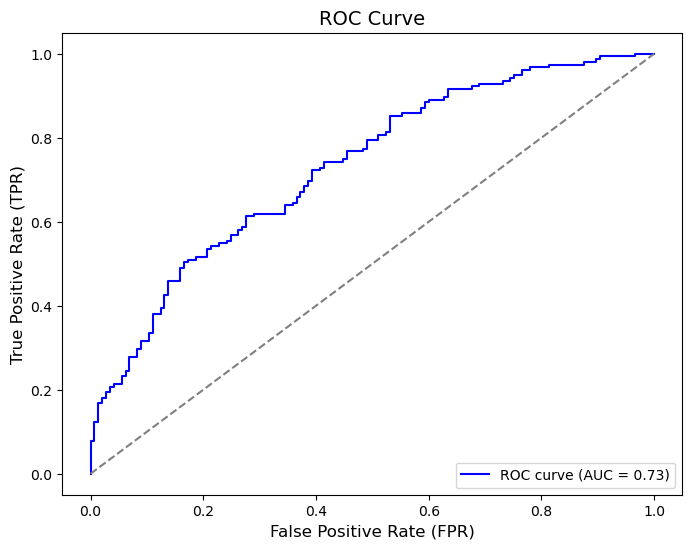

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.show()

#### **4.3.3 Lift Table Example**

A **Lift Table** directly translates a model’s prediction into actionable business terms. It shows how much more efficient a campaign is when it focuses on the top-ranked clients based on predicted probabilities.

The table divides clients into deciles (groups of 10%), ranks them by predicted probability, and calculates the cumulative proportion of responders. For instance, if you contact the top 10% of clients, how many responders will you reach compared to contacting the top 50%?

The table helps in targeting decisions: If the model can accurately predict who is most likely to respond, it minimizes wasted resources by focusing efforts on those clients.

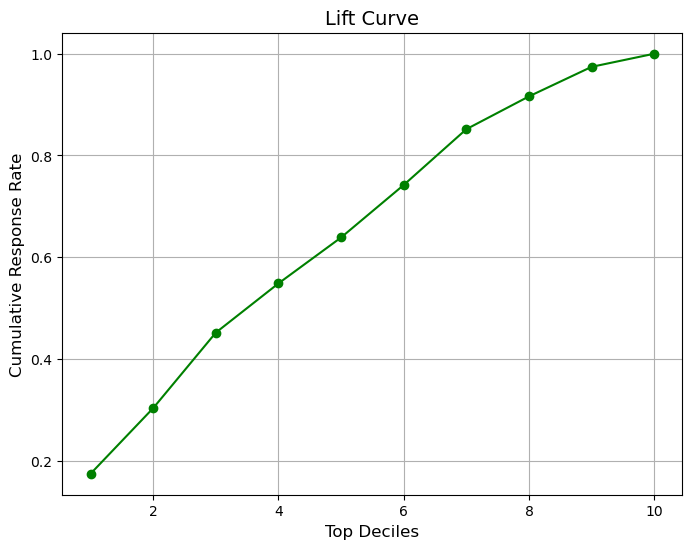

,total_responses,total_clients,response_rate,cumulative_response
decile,,,,
0,27,30,0.900000,0.174194
1,20,30,0.666667,0.303226
2,23,30,0.766667,0.451613
3,15,30,0.500000,0.548387
4,14,30,0.466667,0.638710
5,16,30,0.533333,0.741935
6,17,30,0.566667,0.851613
7,10,30,0.333333,0.916129
8,9,30,0.300000,0.974194


In [3]:
# Sort by predicted probabilities and compute cumulative responders
df = pd.DataFrame({'prob': y_pred_prob, 'actual': y_test})
df['rank'] = df['prob'].rank(ascending=False)

# Create deciles
df['decile'] = pd.qcut(df['rank'], 10, labels=False)

# Calculate the cumulative number of responders
lift_table = df.groupby('decile').agg(
    total_responses=('actual', 'sum'),
    total_clients=('actual', 'count')
)
lift_table['response_rate'] = lift_table['total_responses'] / lift_table['total_clients']
lift_table['cumulative_response'] = lift_table['total_responses'].cumsum() / lift_table['total_responses'].sum()

# Plot Lift Table
plt.figure(figsize=(8, 6))
plt.plot(lift_table.index + 1, lift_table['cumulative_response'], marker='o', color='green')
plt.xlabel('Top Deciles', fontsize=12)
plt.ylabel('Cumulative Response Rate', fontsize=12)
plt.title('Lift Curve', fontsize=14)
plt.grid(True)
plt.show()

lift_table

#### **4.3.4 Business Integration**

Both **AUC** and **Lift** are valuable metrics, but they measure different aspects of model performance.

- **AUC**: Measures how well the model ranks individual clients.
- **Lift**: Measures how much more efficient the campaign becomes when using the model’s ranking.

A model with a high AUC but poor Lift in the top deciles is poorly calibrated for action, meaning it’s not helping marketers target the most responsive clients efficiently.

In a well-performing marketing model, the highest lift should appear in the early deciles of the ranking, where the most profit can be realized.

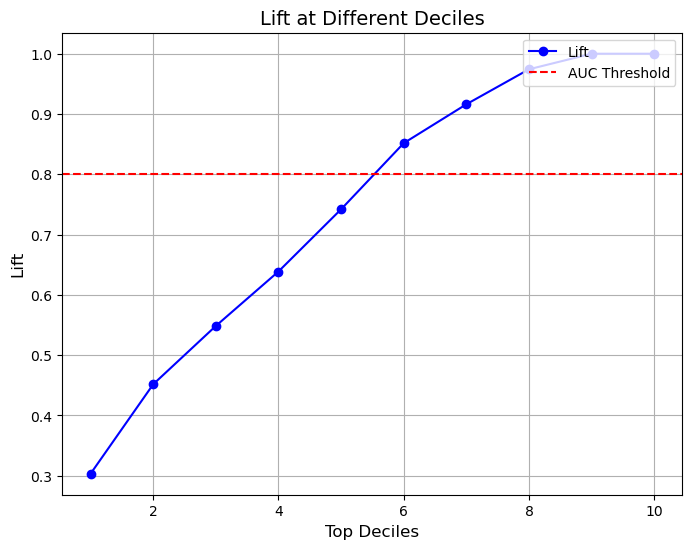

[np.float64(0.3032258064516129),
 np.float64(0.45161290322580644),
 np.float64(0.5483870967741935),
 np.float64(0.6387096774193548),
 np.float64(0.7419354838709677),
 np.float64(0.8516129032258064),
 np.float64(0.9161290322580645),
 np.float64(0.9741935483870968),
 np.float64(1.0),
 np.float64(1.0)]

In [4]:
# Calculate cumulative lift at different decile thresholds
lift_at_deciles = []
for i in range(1, 11):
    decile_clients = df[df['decile'] <= i]
    lift_at_deciles.append(decile_clients['actual'].sum() / df['actual'].sum())

# Plot AUC vs Lift comparison
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), lift_at_deciles, marker='o', color='blue', label='Lift')
plt.axhline(0.8, color='red', linestyle='--', label='AUC Threshold')
plt.xlabel('Top Deciles', fontsize=12)
plt.ylabel('Lift', fontsize=12)
plt.title('Lift at Different Deciles', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

lift_at_deciles